# PWM Sim

## Simulation setup

In [1]:
import pwmsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, lfilter, decimate

In [22]:
signal_freq = 1e3
signal_period = 1/signal_freq
sim_time = 10 * signal_period
sample_freq = 1e6
pwm_max = 64
upsample_factor = 1
sample_period = 1/sample_freq

## Input signal

In [3]:
t = pwmsim.get_time(start=0, ts=sample_period, stop=sim_time)
noise = np.random.rand(len(t))/1000
signal = (0.9*np.sin(2 * np.pi * signal_freq * t) + 1)/2 + noise

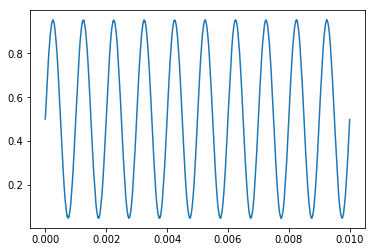

In [4]:
plt.plot(t, signal); plt.show();

## PWM

In [5]:
pwm_out = pwmsim.get_pwm(signal, div=pwm_max)
pwm_period = sample_period / upsample_factor
pwm_freq = 1/pwm_period
pwm_resolution = pwm_period / pwm_max
pwm_time = pwmsim.get_time(start=0, ts=pwm_resolution, num=len(pwm_out))

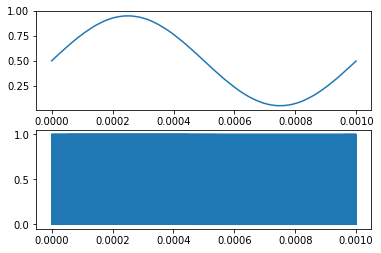

In [6]:
t_end = 0.001
plt.subplot(211); plt.plot(t[t<t_end], signal[t<t_end])
plt.subplot(212); plt.plot(pwm_time[pwm_time<t_end], pwm_out[pwm_time<t_end]);
plt.show();

## PWM Spectrum

In [7]:
fs = 1/pwm_resolution
pwm_f, pwm_spectrum = periodogram(pwm_out.astype(np.float), fs=fs)
#pwm_spectrum += np.ones(len(pwm_spectrum))*1e-10 # Saco los 0s que cagan el log10
pwm_spectrum = 20 * np.log10(pwm_spectrum)
f_res = pwm_f[1]

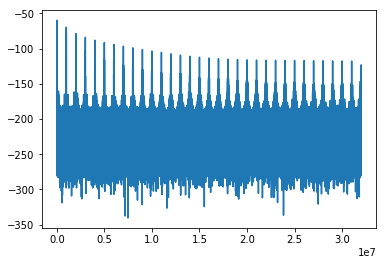

In [8]:
idx = pwm_f > 0
plt.plot(pwm_f[idx], pwm_spectrum[idx]); plt.show();

### PWM Harmonics

Harmonic #0


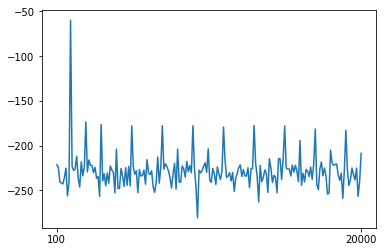

Harmonic #1


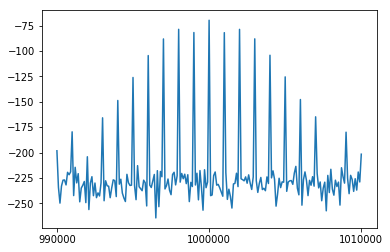

Harmonic #2


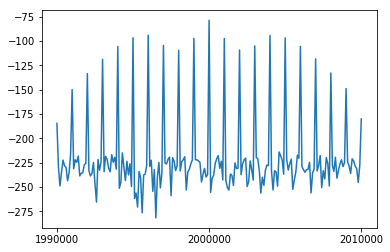

Harmonic #3


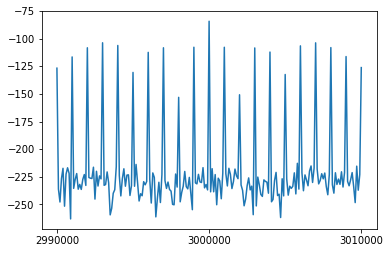

Harmonic #4


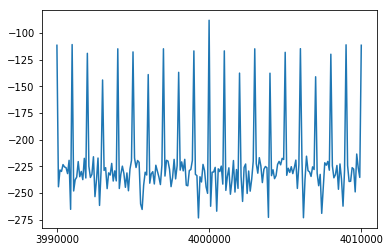

Harmonic #5


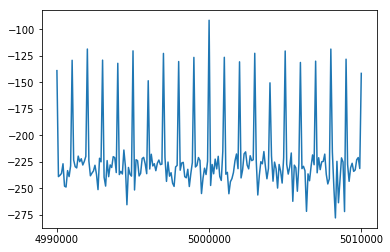

In [9]:
for h in range(6):
    #plt.subplot(2,3,h+1)
    if h == 0:
        idx_start = int(1)
        idx_end = int(signal_freq / f_res * 20)
        ticks = pwm_f[[idx_start, idx_end]]
    else:
        idx_center = int(h * pwm_freq / f_res)
        idx_spam = int(signal_freq / f_res * 20)
        idx_start = int(idx_center - idx_spam/2)
        idx_end = int(idx_center + idx_spam/2)
        ticks = pwm_f[[idx_center, idx_start, idx_end]]
    print("Harmonic #{}".format(h))
    plt.plot(pwm_f[idx_start:idx_end+1], pwm_spectrum[idx_start:idx_end+1])
    plt.xticks(ticks)
    plt.show()


## After bandpass filter

In [10]:
filter = np.load('1M_filter.npz')['ba']

In [11]:
a = filter[1]; b=filter[0];

In [12]:
filtered_pwm = lfilter(b=b, a=a, x=pwm_out)

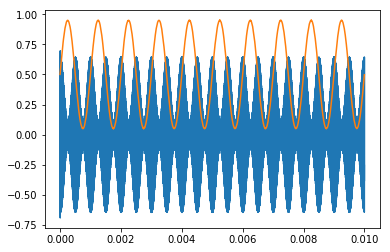

In [13]:
plt.plot(pwm_time, filtered_pwm); plt.plot(t, signal);
plt.show()

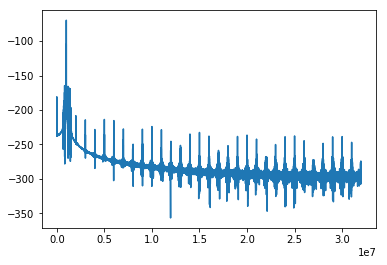

In [14]:
pwm_f, pwm_spectrum = periodogram(filtered_pwm, fs=fs)
plt.plot(pwm_f[pwm_f>0], 20*np.log10(pwm_spectrum)[pwm_f>0]); plt.show();

## Baseband

In [15]:
baseband = filtered_pwm * np.cos(2*np.pi*1e6*pwm_time)
f, p = periodogram(baseband, fs=fs)

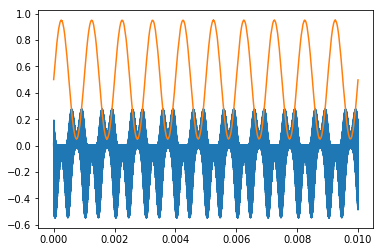

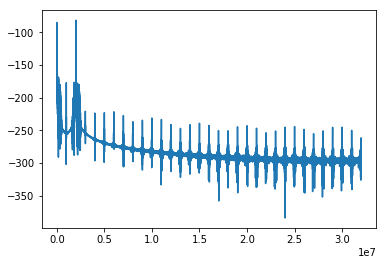

In [16]:
plt.plot(pwm_time, baseband); 
plt.plot(t, signal); plt.show();
idx = f>0
plt.plot(f[idx],20*np.log10(p[idx])); plt.show()

In [17]:
filter = np.load('1M_LPF.npz')['ba']

In [18]:
a = filter[1]; b=filter[0];

In [19]:
baseband = lfilter(b=b, a=a, x=baseband)

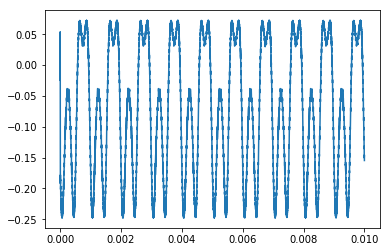

In [20]:
plt.plot(pwm_time, baseband); plt.show()

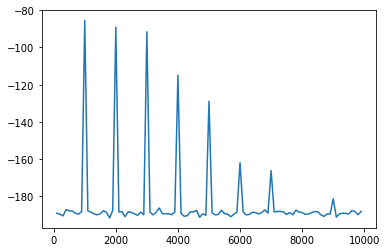

In [21]:
f, p = periodogram(baseband, fs=fs); idx = (f>0) & (f<10e3)
plt.plot(f[idx],20*np.log10(p[idx])); plt.show();